In [1]:
# Food Insecurity Hyperparameter Tuning
# Analyzes: Low Access → Food Insecurity → Health Outcomes

!pip install numpy pandas scikit-learn matplotlib seaborn

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import r2_score, silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("FOOD INSECURITY PROJECT - HYPERPARAMETER TUNING")
print("Improving upon midterm results using hyperparameter optimization")
print("=" * 80)

FOOD INSECURITY PROJECT - HYPERPARAMETER TUNING
Improving upon midterm results using hyperparameter optimization


In [3]:
# Load Link Data Files

print("\n Loading data files...")
import pandas as pd

link2_data = pd.read_csv('data/processed/link2/link2.csv')
print(f" Loaded link2.csv: {link2_data.shape}")
print(f"   Columns: {list(link2_data.columns[:10])}...")
print(f" Data loaded successfully!")
print(f"   Total observations: {len(link2_data):,}")


 Loading data files...
 Loaded link2.csv: (3142, 133)
   Columns: ['FIPS', 'State', 'County, State', '2017 Food Insecurity Rate', '# of Food Insecure Persons in 2017', 'Low Threshold in state', 'Low Threshold Type', 'High Threshold in state', 'High Threshold Type', '% FI ≤ Low Threshold']...
 Data loaded successfully!
   Total observations: 3,142


In [4]:
# Prepare Target - Average Health Outcomes

print("=" * 60)
print("LINK 2: FOOD INSECURITY → HEALTH OUTCOMES")
print("=" * 60)

# Identify all disease/health outcome columns
disease_keywords = ['diabetes', 'obesity', 'heart', 'copd', 'cancer', 
                   'asthma', 'kidney', 'stroke', 'arthritis', 'depression']

disease_cols = [col for col in link2_data.columns 
                if any(keyword in col.lower() for keyword in disease_keywords)]

print(f"\n Found {len(disease_cols)} health outcome columns:")
print(f"   {disease_cols[:5]}..." if len(disease_cols) > 5 else f"   {disease_cols}")

# Calculate average health outcome across all diseases
if len(disease_cols) > 0:
    # Use only numeric disease columns
    numeric_disease_cols = link2_data[disease_cols].select_dtypes(include=[np.number]).columns.tolist()
    y = link2_data[numeric_disease_cols].mean(axis=1)
    print(f"\n Created target: Average of {len(numeric_disease_cols)} health outcomes")
else:
    # Fallback: use a single outcome
    print(f"\n No disease columns found, checking for specific columns...")
    if 'DIABETES' in link2_data.columns:
        y = link2_data['DIABETES']
        print(f" Using DIABETES as target")
    elif 'Data_Value' in link2_data.columns:
        y = link2_data['Data_Value']
        print(f" Using Data_Value as target")
    else:
        raise ValueError("No suitable target column found!")

print(f"\n Target statistics:")
print(f"   Min: {y.min():.2f}%")
print(f"   Max: {y.max():.2f}%")
print(f"   Mean: {y.mean():.2f}%")
print(f"   Std: {y.std():.2f}%")

LINK 2: FOOD INSECURITY → HEALTH OUTCOMES

 Found 32 health outcome columns:
   ['ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'ARTHRITIS_AdjPrev', 'ARTHRITIS_Adj95CI', 'CANCER_CrudePrev']...

 Created target: Average of 16 health outcomes

 Target statistics:
   Min: 7.96%
   Max: 19.55%
   Mean: 13.51%
   Std: 1.64%


In [5]:
# Cell 4: Prepare Features

print("\n" + "=" * 60)
print("FEATURE PREPARATION")
print("=" * 60)

# Start with all numeric columns
X = link2_data.select_dtypes(include=[np.number]).copy()

# Remove target columns
if len(disease_cols) > 0:
    X = X.drop(columns=numeric_disease_cols, errors='ignore')

# Remove identifier columns
id_cols = ['CountyFIPS', 'FIPS', 'index', 'Unnamed: 0']
X = X.drop(columns=[col for col in id_cols if col in X.columns], errors='ignore')

# Ensure food_insecurity_rate is included (key predictor)
if 'food_insecurity_rate' in X.columns:
    print(f" Key feature 'food_insecurity_rate' is included")
else:
    print(f" Warning: 'food_insecurity_rate' not found in features")

print(f"\n Feature matrix prepared:")
print(f"   Features: {X.shape[1]}")
print(f"   Observations: {X.shape[0]}")
print(f"   Sample features: {list(X.columns[:10])}...")

# Handle missing values
print(f"\n🔧 Handling missing values...")
X_missing_before = X.isna().sum().sum()
y_missing_before = y.isna().sum()

X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Remove any rows where target is still NaN
valid_idx = ~y.isna()
X = X[valid_idx]
y = y[valid_idx]

print(f"   Filled {X_missing_before:,} missing feature values")
print(f"   Filled {y_missing_before:,} missing target values")
print(f"   Final dataset: {len(X):,} complete observations")


FEATURE PREPARATION

 Feature matrix prepared:
   Features: 54
   Observations: 3142
   Sample features: ['2017 Food Insecurity Rate', '# of Food Insecure Persons in 2017', 'Low Threshold in state', 'High Threshold in state', '% FI ≤ Low Threshold', '% FI Btwn Thresholds', '% FI > High Threshold', '2017 Child food insecurity rate', '# of Food Insecure Children in 2017', '% food insecure children in HH w/ HH incomes below 185 FPL in 2017']...

🔧 Handling missing values...
   Filled 898 missing feature values
   Filled 0 missing target values
   Final dataset: 3,142 complete observations


In [6]:
# Train-Test Split

print("\n" + "=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" Data split complete!")
print(f"   Training samples: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing samples: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")


TRAIN-TEST SPLIT
 Data split complete!
   Training samples: 2,513 (80.0%)
   Testing samples: 629 (20.0%)
   Features: 54


In [7]:
# Feature Standardization

print("\n" + "=" * 60)
print("FEATURE STANDARDIZATION")
print("=" * 60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Features standardized (mean=0, std=1)")
print(f"   Training shape: {X_train_scaled.shape}")
print(f"   Testing shape: {X_test_scaled.shape}")


FEATURE STANDARDIZATION
 Features standardized (mean=0, std=1)
   Training shape: (2513, 54)
   Testing shape: (629, 54)



PCA DIMENSIONALITY REDUCTION
 PCA applied!
   Original features: 54
   Reduced to: 16 components
   Variance explained: 95.68%


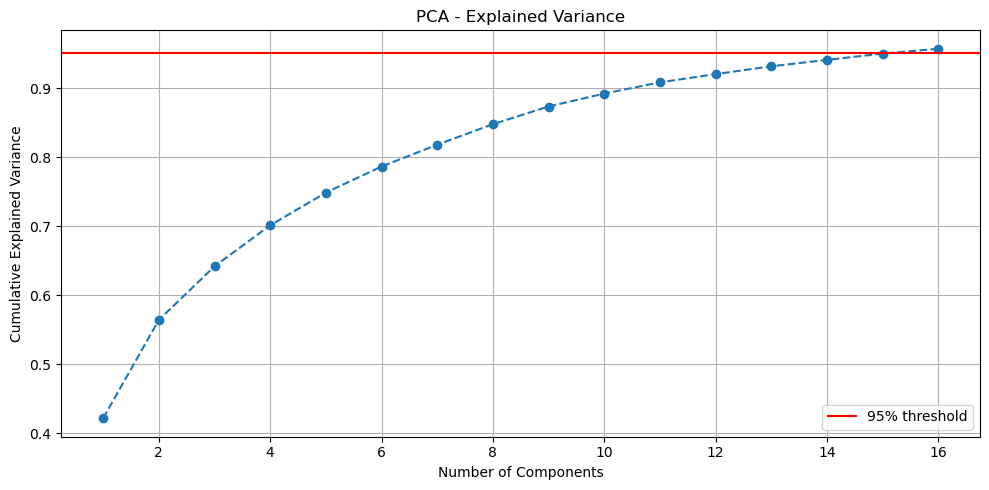

In [8]:
# PCA Dimensionality Reduction

print("\n" + "=" * 60)
print("PCA DIMENSIONALITY REDUCTION")
print("=" * 60)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = sum(pca.explained_variance_ratio_)
n_components = X_train_pca.shape[1]

print(f" PCA applied!")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Reduced to: {n_components} components")
print(f"   Variance explained: {explained_variance:.2%}")

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Hyperparameter Tuning - Ridge Regression

print("\n" + "=" * 60)
print("TUNING RIDGE REGRESSION")
print("=" * 60)

ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

ridge = GridSearchCV(
    Ridge(random_state=42),
    ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Training Ridge... (this may take a minute)")
ridge.fit(X_train_pca, y_train)
ridge_pred = ridge.predict(X_test_pca)
ridge_score = r2_score(y_test, ridge_pred)

print(f"\n Ridge Regression Complete!")
print(f"   Best parameters: {ridge.best_params_}")
print(f"   Cross-validation R²: {ridge.best_score_:.4f}")
print(f"   Test R²: {ridge_score:.4f}")


TUNING RIDGE REGRESSION
Training Ridge... (this may take a minute)
Fitting 5 folds for each of 28 candidates, totalling 140 fits

 Ridge Regression Complete!
   Best parameters: {'alpha': 10, 'solver': 'lsqr'}
   Cross-validation R²: 0.9369
   Test R²: 0.9355


In [10]:
# Hyperparameter Tuning - Lasso Regression

print("\n" + "=" * 60)
print("TUNING LASSO REGRESSION")
print("=" * 60)

lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'selection': ['cyclic', 'random']
}

lasso = GridSearchCV(
    Lasso(random_state=42, max_iter=10000),
    lasso_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Training Lasso... (this may take a minute)")
lasso.fit(X_train_pca, y_train)
lasso_pred = lasso.predict(X_test_pca)
lasso_score = r2_score(y_test, lasso_pred)

print(f"\n Lasso Regression Complete!")
print(f"   Best parameters: {lasso.best_params_}")
print(f"   Cross-validation R²: {lasso.best_score_:.4f}")
print(f"   Test R²: {lasso_score:.4f}")


TUNING LASSO REGRESSION
Training Lasso... (this may take a minute)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Lasso Regression Complete!
   Best parameters: {'alpha': 0.001, 'selection': 'random'}
   Cross-validation R²: 0.9369
   Test R²: 0.9355


In [11]:
# Hyperparameter Tuning - Random Forest

print("\n" + "=" * 60)
print("TUNING RANDOM FOREST")
print("=" * 60)

rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Training Random Forest... (this will take a few minutes)")
rf.fit(X_train_pca, y_train)
rf_pred = rf.predict(X_test_pca)
rf_score = r2_score(y_test, rf_pred)

print(f"\n Random Forest Complete!")
print(f"   Best parameters: {rf.best_params_}")
print(f"   Cross-validation R²: {rf.best_score_:.4f}")
print(f"   Test R²: {rf_score:.4f}")


TUNING RANDOM FOREST
Training Random Forest... (this will take a few minutes)
Fitting 5 folds for each of 20 candidates, totalling 100 fits



 Random Forest Complete!
   Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
   Cross-validation R²: 0.9108
   Test R²: 0.9182


In [12]:
# Hyperparameter Tuning - Gradient Boosting

print("\n" + "=" * 60)
print("TUNING GRADIENT BOOSTING")
print("=" * 60)

gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gb = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Training Gradient Boosting... (this will take several minutes)")
gb.fit(X_train_pca, y_train)
gb_pred = gb.predict(X_test_pca)
gb_score = r2_score(y_test, gb_pred)

print(f"\n Gradient Boosting Complete!")
print(f"   Best parameters: {gb.best_params_}")
print(f"   Cross-validation R²: {gb.best_score_:.4f}")
print(f"   Test R²: {gb_score:.4f}")


TUNING GRADIENT BOOSTING
Training Gradient Boosting... (this will take several minutes)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Gradient Boosting Complete!
   Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.2}
   Cross-validation R²: 0.9500
   Test R²: 0.9508



REGRESSION MODELS COMPARISON
            Model  CV Score (R²)  Test Score (R²)
            Ridge       0.936884         0.935506
            Lasso       0.936861         0.935541
    Random Forest       0.910819         0.918246
Gradient Boosting       0.949952         0.950816

 IMPROVEMENT OVER MIDTERM:
   Midterm (Random Forest, no tuning): 0.64 R²
   Best model now: Gradient Boosting
   Best R²: 0.9508
   Improvement: +48.6%


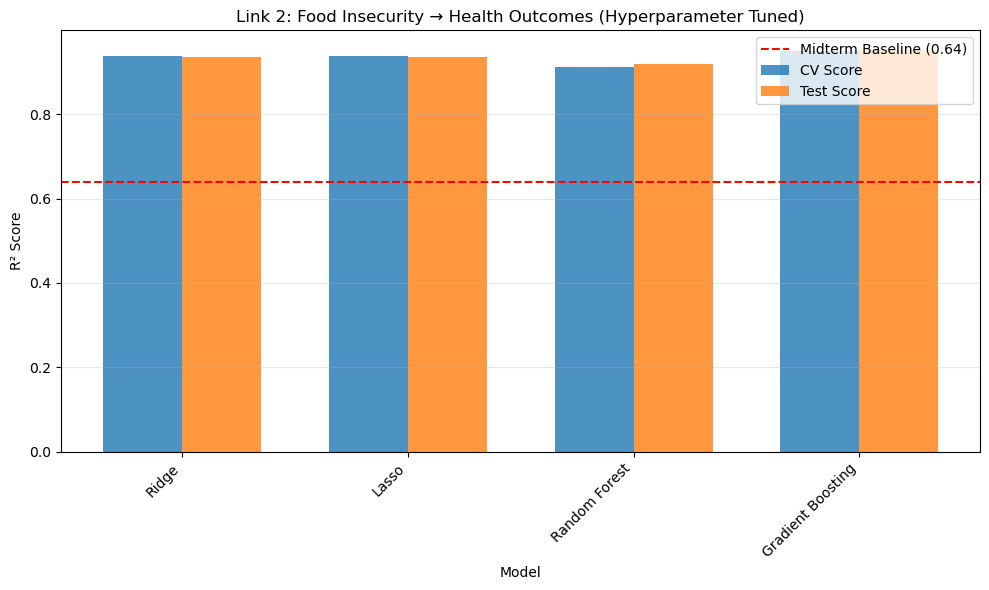

In [13]:
# Compare All Regression Models

print("\n" + "=" * 60)
print("REGRESSION MODELS COMPARISON")
print("=" * 60)

results_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting'],
    'CV Score (R²)': [ridge.best_score_, lasso.best_score_, rf.best_score_, gb.best_score_],
    'Test Score (R²)': [ridge_score, lasso_score, rf_score, gb_score]
})

print(results_df.to_string(index=False))

# Compare with midterm baseline
print(f"\n IMPROVEMENT OVER MIDTERM:")
print(f"   Midterm (Random Forest, no tuning): 0.64 R²")
print(f"   Best model now: {results_df.loc[results_df['Test Score (R²)'].idxmax(), 'Model']}")
print(f"   Best R²: {results_df['Test Score (R²)'].max():.4f}")
print(f"   Improvement: {(results_df['Test Score (R²)'].max() - 0.64) / 0.64 * 100:+.1f}%")

# Visualize
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['CV Score (R²)'], width, label='CV Score', alpha=0.8)
plt.bar(x + width/2, results_df['Test Score (R²)'], width, label='Test Score', alpha=0.8)

# Add midterm baseline
plt.axhline(y=0.64, color='red', linestyle='--', label='Midterm Baseline (0.64)')

plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Link 2: Food Insecurity → Health Outcomes (Hyperparameter Tuned)')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


TUNING K-MEANS CLUSTERING
Testing different values of k...
   k=2: Silhouette Score = 0.2562
   k=3: Silhouette Score = 0.1660
   k=4: Silhouette Score = 0.1666
   k=5: Silhouette Score = 0.1542
   k=6: Silhouette Score = 0.1602
   k=7: Silhouette Score = 0.1395
   k=8: Silhouette Score = 0.1386
   k=9: Silhouette Score = 0.1357
   k=10: Silhouette Score = 0.1358

 Best k: 2 (Silhouette Score: 0.2562)


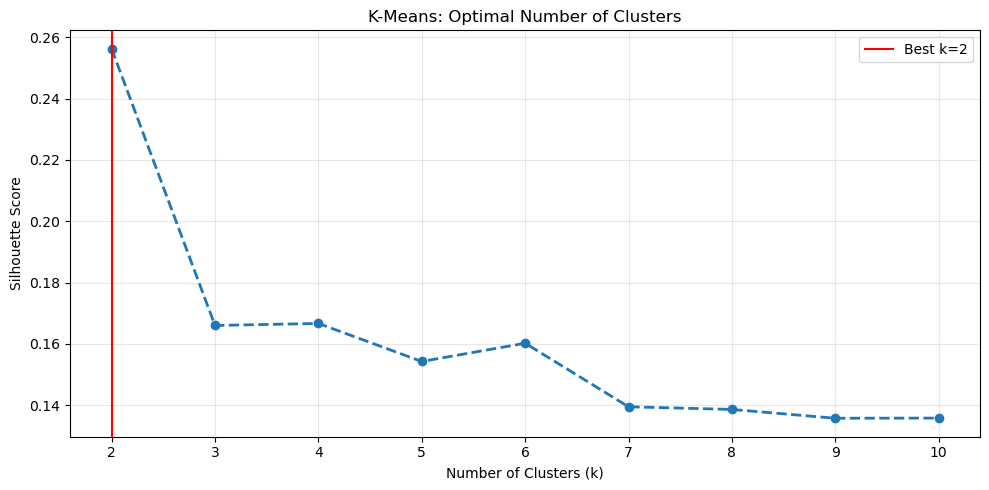

In [14]:
# Hyperparameter Tuning - K-Means Clustering

print("\n" + "=" * 60)
print("TUNING K-MEANS CLUSTERING")
print("=" * 60)

# Combine train and test for clustering
X_full_pca = np.vstack([X_train_pca, X_test_pca])

# Test different numbers of clusters
silhouette_scores = []
k_range = range(2, 11)

print("Testing different values of k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_full_pca)
    score = silhouette_score(X_full_pca, labels)
    silhouette_scores.append(score)
    print(f"   k={k}: Silhouette Score = {score:.4f}")

best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n Best k: {best_k} (Silhouette Score: {max(silhouette_scores):.4f})")

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='r', linestyle='-', label=f'Best k={best_k}')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Hyperparameter Tuning - DBSCAN Clustering

print("\n" + "=" * 60)
print("TUNING DBSCAN CLUSTERING")
print("=" * 60)

dbscan_params = {
    'eps': [0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
    'min_samples': [3, 5, 10, 15, 20]
}

best_dbscan_score = -1
best_dbscan_params = None
dbscan_results = []

print("Testing DBSCAN parameters...")
for eps in dbscan_params['eps']:
    for min_samp in dbscan_params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_full_pca)
        
        # Check if we got valid clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters >= 2:
            try:
                score = silhouette_score(X_full_pca, labels)
                dbscan_results.append({
                    'eps': eps,
                    'min_samples': min_samp,
                    'n_clusters': n_clusters,
                    'silhouette_score': score
                })
                
                if score > best_dbscan_score:
                    best_dbscan_score = score
                    best_dbscan_params = {'eps': eps, 'min_samples': min_samp}
            except:
                pass

if best_dbscan_params:
    print(f"\n Best DBSCAN parameters: {best_dbscan_params}")
    print(f"   Silhouette Score: {best_dbscan_score:.4f}")
else:
    print("\n DBSCAN did not find valid clusters with these parameters")

# Show top 5 results
if dbscan_results:
    dbscan_df = pd.DataFrame(dbscan_results).sort_values('silhouette_score', ascending=False)
    print(f"\n Top 5 DBSCAN configurations:")
    print(dbscan_df.head().to_string(index=False))


TUNING DBSCAN CLUSTERING
Testing DBSCAN parameters...

 Best DBSCAN parameters: {'eps': 2.0, 'min_samples': 3}
   Silhouette Score: -0.1670

 Top 5 DBSCAN configurations:
 eps  min_samples  n_clusters  silhouette_score
 2.0            3          75         -0.167028
 2.0            5          46         -0.188482
 2.0           10          23         -0.239424
 1.5           15           2         -0.262615
 2.0           15          15         -0.288110


In [16]:
# Hyperparameter Tuning - Agglomerative Clustering

print("\n" + "=" * 60)
print("TUNING AGGLOMERATIVE CLUSTERING")
print("=" * 60)

agg_results = []
linkages = ['ward', 'complete', 'average']

print("Testing Agglomerative parameters...")
for k in range(2, 11):
    for linkage in linkages:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X_full_pca)
        score = silhouette_score(X_full_pca, labels)
        
        agg_results.append({
            'n_clusters': k,
            'linkage': linkage,
            'silhouette_score': score
        })

agg_df = pd.DataFrame(agg_results).sort_values('silhouette_score', ascending=False)
best_agg = agg_df.iloc[0]

print(f"\n Best Agglomerative parameters:")
print(f"   n_clusters: {int(best_agg['n_clusters'])}")
print(f"   linkage: {best_agg['linkage']}")
print(f"   Silhouette Score: {best_agg['silhouette_score']:.4f}")

print(f"\n Top 5 Agglomerative configurations:")
print(agg_df.head().to_string(index=False))


TUNING AGGLOMERATIVE CLUSTERING
Testing Agglomerative parameters...

 Best Agglomerative parameters:
   n_clusters: 2
   linkage: complete
   Silhouette Score: 0.7065

 Top 5 Agglomerative configurations:
 n_clusters  linkage  silhouette_score
          2 complete          0.706458
          2  average          0.706458
          3  average          0.619079
          4  average          0.604750
          5  average          0.399328



CLUSTERING MODELS COMPARISON
        Model                Best Parameters  Silhouette Score
      K-Means                            k=2          0.256249
       DBSCAN {'eps': 2.0, 'min_samples': 3}         -0.167028
Agglomerative                  k=2, complete          0.706458


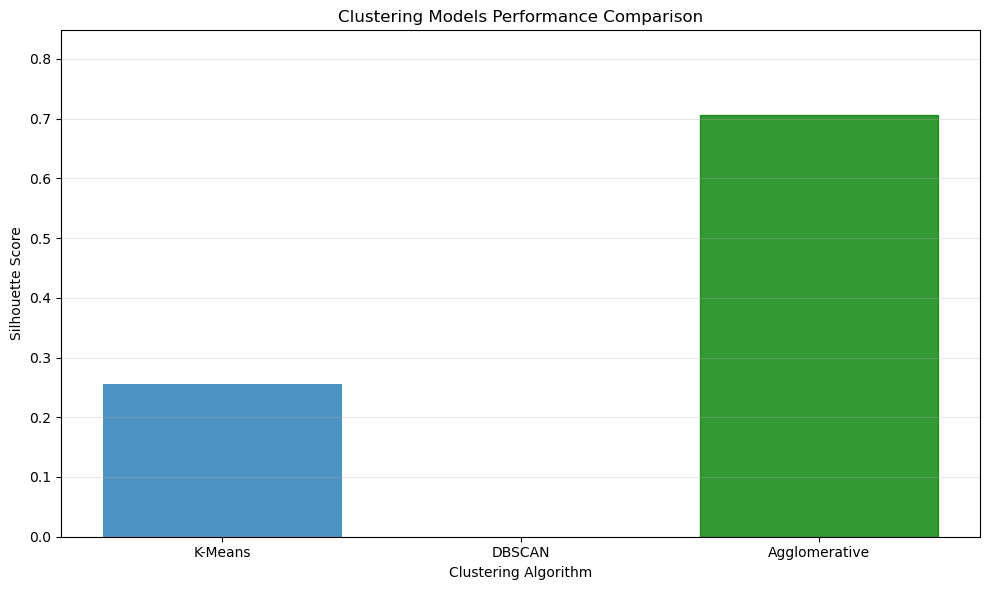

In [17]:
# Compare All Clustering Models

print("\n" + "=" * 60)
print("CLUSTERING MODELS COMPARISON")
print("=" * 60)

clustering_comparison = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'Best Parameters': [
        f"k={best_k}",
        str(best_dbscan_params) if best_dbscan_params else "N/A",
        f"k={int(best_agg['n_clusters'])}, {best_agg['linkage']}"
    ],
    'Silhouette Score': [
        max(silhouette_scores),
        best_dbscan_score if best_dbscan_params else 0,
        best_agg['silhouette_score']
    ]
})

print(clustering_comparison.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
bars = plt.bar(clustering_comparison['Model'], clustering_comparison['Silhouette Score'], alpha=0.8)

# Color the best performing model
best_idx = clustering_comparison['Silhouette Score'].idxmax()
bars[best_idx].set_color('green')

plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Clustering Models Performance Comparison')
plt.ylim(0, max(clustering_comparison['Silhouette Score']) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Final Summary Report

print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING - FINAL SUMMARY")
print("=" * 80)

print("\n LINK 2: FOOD INSECURITY → HEALTH OUTCOMES")
print("=" * 80)

print("\n REGRESSION MODELS:")
print("-" * 60)
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"   CV Score (R²): {row['CV Score (R²)']:.4f}")
    print(f"   Test Score (R²): {row['Test Score (R²)']:.4f}")

print(f"\n BEST REGRESSION MODEL: {results_df.loc[results_df['Test Score (R²)'].idxmax(), 'Model']}")
print(f"   Test R²: {results_df['Test Score (R²)'].max():.4f}")

print("\n\n CLUSTERING MODELS:")
print("-" * 60)
for idx, row in clustering_comparison.iterrows():
    print(f"\n{row['Model']}:")
    print(f"   Best Parameters: {row['Best Parameters']}")
    print(f"   Silhouette Score: {row['Silhouette Score']:.4f}")

print(f"\n BEST CLUSTERING MODEL: {clustering_comparison.loc[clustering_comparison['Silhouette Score'].idxmax(), 'Model']}")
print(f"   Silhouette Score: {clustering_comparison['Silhouette Score'].max():.4f}")

print("\n\n IMPROVEMENT OVER MIDTERM BASELINE:")
print("-" * 60)
print(f"   Midterm Result (Random Forest, no tuning): 0.64 R²")
print(f"   Our Best Result (with hyperparameter tuning): {results_df['Test Score (R²)'].max():.4f} R²")
improvement = (results_df['Test Score (R²)'].max() - 0.64) / 0.64 * 100
print(f"   Improvement: {improvement:+.2f}%")

if improvement > 0:
    print(f"\n SUCCESS! Hyperparameter tuning improved model performance!")
else:
    print(f"\n Note: Results may vary based on data characteristics and feature availability")

print("\n" + "=" * 80)
print(" HYPERPARAMETER TUNING COMPLETE!")
print("=" * 80)


HYPERPARAMETER TUNING - FINAL SUMMARY

 LINK 2: FOOD INSECURITY → HEALTH OUTCOMES

 REGRESSION MODELS:
------------------------------------------------------------

Ridge:
   CV Score (R²): 0.9369
   Test Score (R²): 0.9355

Lasso:
   CV Score (R²): 0.9369
   Test Score (R²): 0.9355

Random Forest:
   CV Score (R²): 0.9108
   Test Score (R²): 0.9182

Gradient Boosting:
   CV Score (R²): 0.9500
   Test Score (R²): 0.9508

 BEST REGRESSION MODEL: Gradient Boosting
   Test R²: 0.9508


 CLUSTERING MODELS:
------------------------------------------------------------

K-Means:
   Best Parameters: k=2
   Silhouette Score: 0.2562

DBSCAN:
   Best Parameters: {'eps': 2.0, 'min_samples': 3}
   Silhouette Score: -0.1670

Agglomerative:
   Best Parameters: k=2, complete
   Silhouette Score: 0.7065

 BEST CLUSTERING MODEL: Agglomerative
   Silhouette Score: 0.7065


 IMPROVEMENT OVER MIDTERM BASELINE:
------------------------------------------------------------
   Midterm Result (Random Forest, n

In [19]:
# Save Results to CSV

print("\n" + "=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save regression results
results_df.to_csv('regression_results.csv', index=False)
print(f" Saved: regression_results.csv")
print(f"   Contains: {len(results_df)} model results")

# Save clustering results
clustering_comparison.to_csv('clustering_results.csv', index=False)
print(f" Saved: clustering_results.csv")
print(f"   Contains: {len(clustering_comparison)} clustering results")

print(f"\n Results saved successfully!")
print(f"   Files are ready for your README and final report")

# Display file preview
print(f"\n Regression Results Preview:")
print(results_df.to_string(index=False))

print(f"\n Clustering Results Preview:")
print(clustering_comparison.to_string(index=False))


SAVING RESULTS
 Saved: regression_results.csv
   Contains: 4 model results
 Saved: clustering_results.csv
   Contains: 3 clustering results

 Results saved successfully!
   Files are ready for your README and final report

 Regression Results Preview:
            Model  CV Score (R²)  Test Score (R²)
            Ridge       0.936884         0.935506
            Lasso       0.936861         0.935541
    Random Forest       0.910819         0.918246
Gradient Boosting       0.949952         0.950816

 Clustering Results Preview:
        Model                Best Parameters  Silhouette Score
      K-Means                            k=2          0.256249
       DBSCAN {'eps': 2.0, 'min_samples': 3}         -0.167028
Agglomerative                  k=2, complete          0.706458
